In [1]:
import datetime as dt
import os

import src.project_definitions as eb

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

from src import style, graphs, update_databases
style.set_rc_eb_standard()
import src.utilities as ut
import src.sensor_reader as sr

plt.rcParams['text.usetex'] = False
import locale
locale.setlocale(locale.LC_ALL,'de_DE')

### ACHTUNG: Diese Zeilen nur aktivieren wenn Sicher ist, dass der Code funktioniert.
import warnings
warnings.filterwarnings('ignore')

##### READ Data #####
IND = {bui: sr.load_tf_bui(bui, '1min') for bui in eb.buid})
AMB = pd.merge(sr.load_tf_weather('1min'), sr.load_tf_pm('1min'), left_index=True, right_index=True)

##### USER INPUTS #####
ex = False

Tinkerforge up-to-date
EnergyMeter up-to-date


--- plotting Mauerwerk | Wohnung Süd | Bad ---
--- plotting Mauerwerk | Wohnung Süd | Flur ---
--- plotting Mauerwerk | Wohnung Süd | Küche ---
--- plotting Mauerwerk | Wohnung Süd | Schlafzimmer ---
--- plotting Mauerwerk | Wohnung Süd | Wohnzimmer ---
Done!


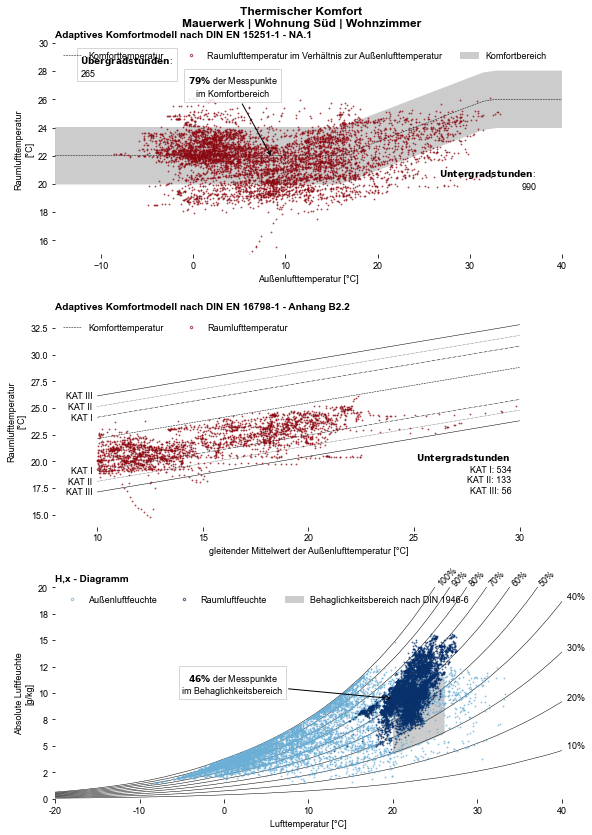

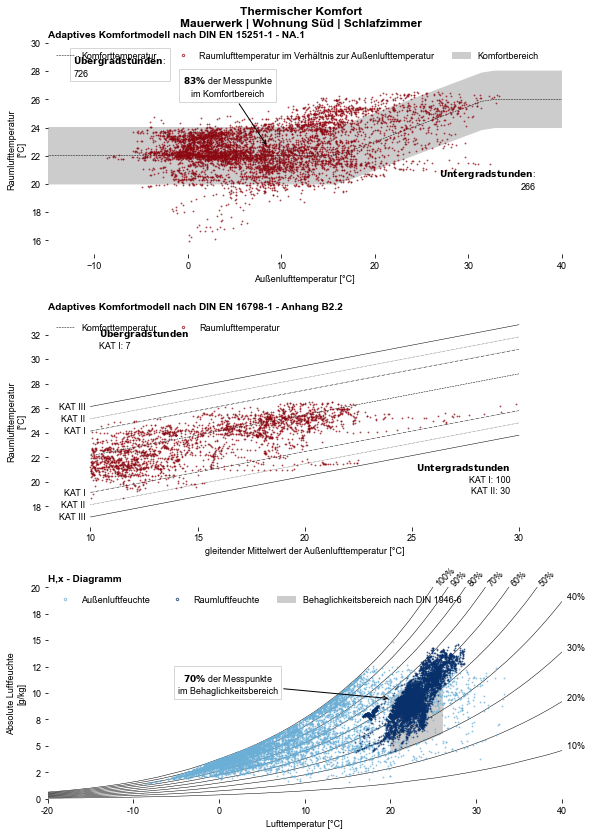

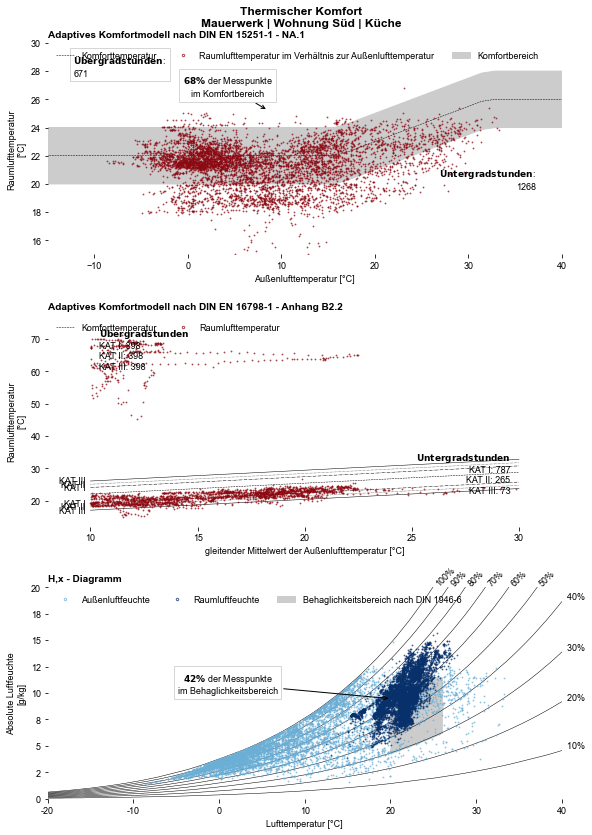

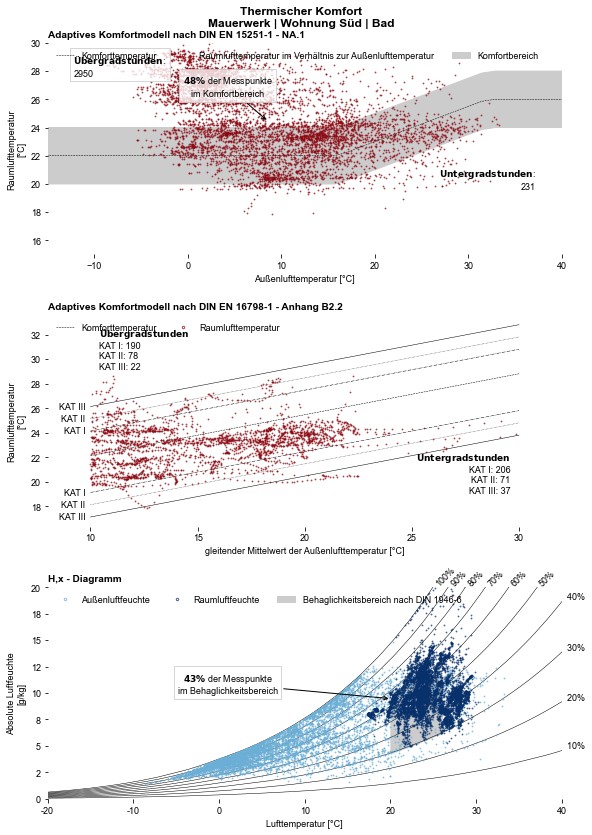

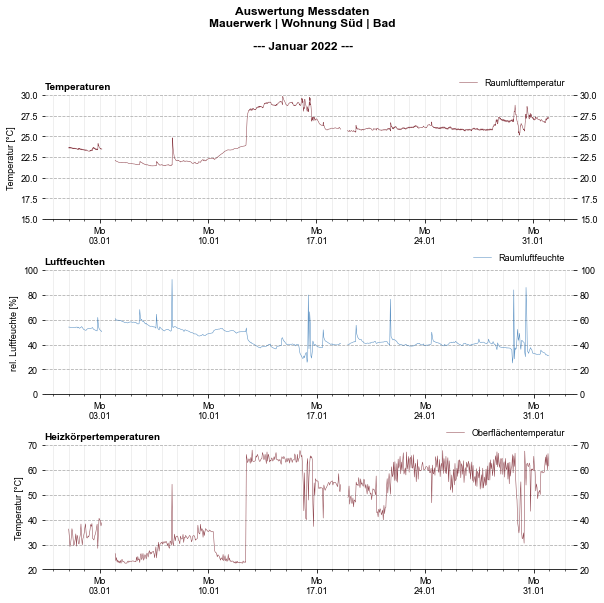

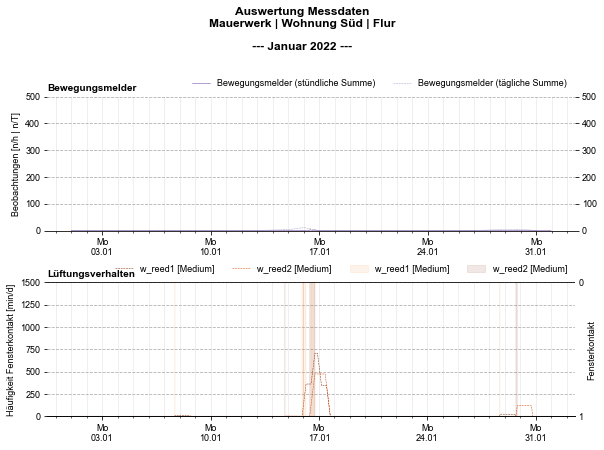

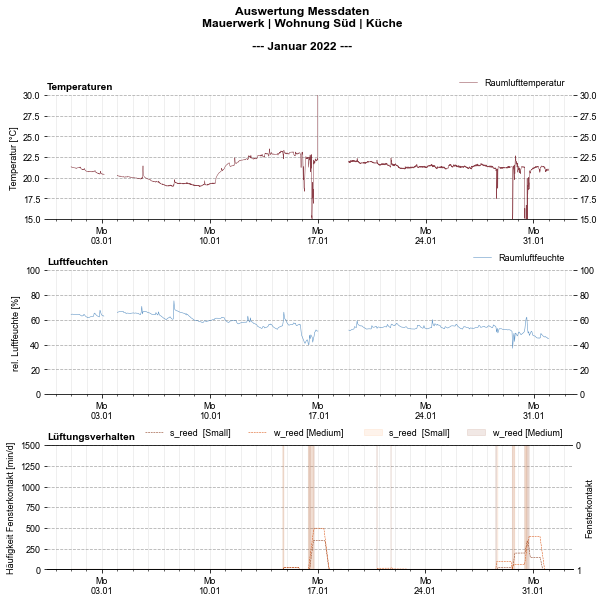

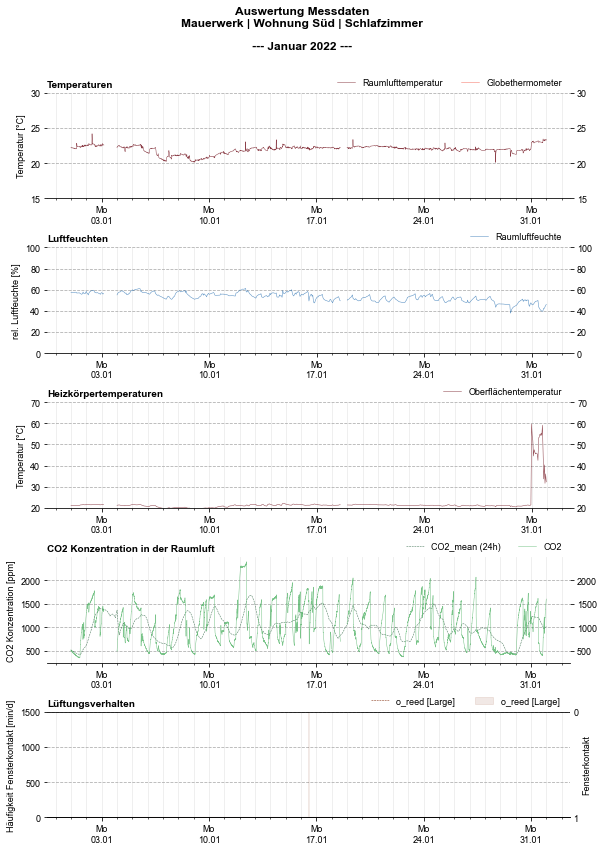

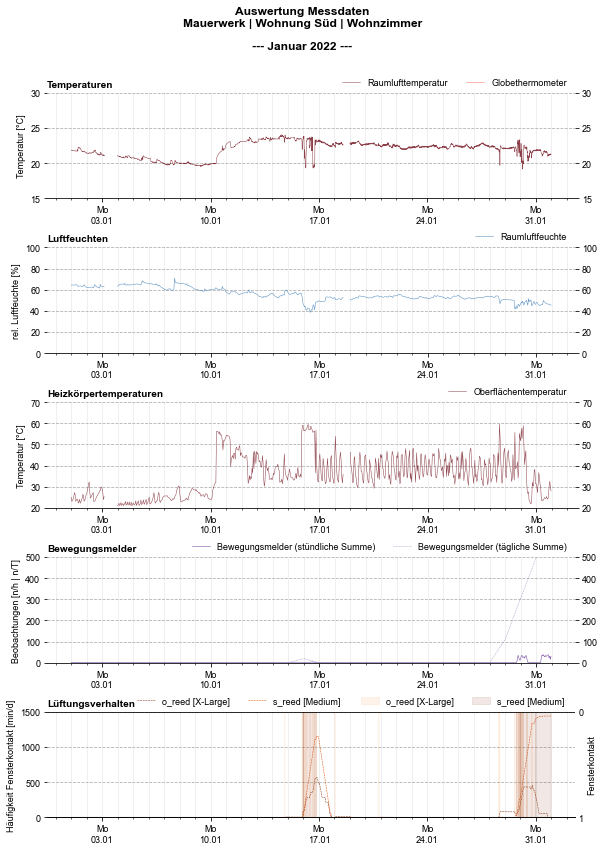

In [2]:
if ex:
    buid = eb.buid
    wohnungen = eb.wohnungen
    rooms = eb.rooms    
else:
    buid = ['MW']
    wohnungen = ['S']
    rooms = eb.rooms

for b, bui in enumerate(buid):
    for a, app in enumerate(wohnungen):
        for room in ['WZ', 'SZ', 'K', 'B', 'SWK']:
                    if room in IND[bui][app].columns.get_level_values(level=0).unique():
                        #with PdfPages(os.path.join(os.path.join(eb.dir_results,'Monatliche Übersicht',eb.buid[bui],eb.wohnungen[app],f'{bui}_{app}_Thermischer_Comfort.pdf'))):
                            fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = style.din_a4)
                            #fig.tight_layout()

                            fig.suptitle(f'Thermischer Komfort\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n', fontweight = 'bold')

                            #plt.subplots_adjust(left=.2, bottom=None, right=.98, top=None, wspace=None, hspace=.5)

                            tamb = AMB['T_amb'].resample('H').last()
                            tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                            rhamb = AMB['Rh_amb'].resample('H').last()

                            test = IND[bui][app][room].filter(like='trh_Tair (°C)')
                            if len(test.columns) == 1:
                                troom = test.resample('H').last()
                            else:
                                print('{bui}-{app}-{room} | Temperatursensor konnte nicht zugeordnet werden.')
                                troom = None

                            test = IND[bui][app][room].filter(like='trh_RH (%)')
                            if len(test.columns) == 1:
                                rhroom = test.resample('H').last()
                            else:
                                print('{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                rhroom = None
                            
                            #fig, ax1 = plt.subplots()
                            #----#7.1: Thermal Comfort 1 ----
                            if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                graphs.thermal_comfort_1(
                                    TAMB = tamb,
                                    TROOM = troom,
                                    ax = ax1,
                                    mode = 'air',
                                    legend_ms=3
                                    )  
                            #fig, ax2 = plt.subplots()
                            #----#7.2: Thermal Comfort 2 ----
                            if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb_g24,(pd.Series, pd.DataFrame)):
                                graphs.thermal_comfort_2(
                                    TAMBG24 = tamb_g24,
                                    TROOM = troom,
                                    ax=ax2,
                                    mode = 'air',
                                    legend_ms=3
                                    )
                            #fig, ax3 = plt.subplots()
                            #----#7.3: H,x - Diagramm ----
                            if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(rhroom,(pd.Series, pd.DataFrame)):
                                graphs.comfort_hx_diagramm(
                                    t1 = troom,
                                    rh1 = rhroom,
                                    rh2 = rhamb,
                                    t2 = tamb,
                                    ax = ax3,
                                    legend_ms=3
                                    )
                            fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    for date, ind in IND[bui].groupby(by=[IND[bui].index.month, IND[bui].index.year]):
        date = dt.date(date[1], date[0], 1)
        amb = AMB[AMB.index.month == date.month]
        for a, app in enumerate(wohnungen):
            with PdfPages(os.path.join(eb.dir_results,'Monatliche Übersicht',eb.buid[bui],eb.wohnungen[app],f'{bui}_{app}_Raumklima_{date:%y%m}.pdf')) as pdf:
                for room in rooms:
                    if room in ind[app].columns.get_level_values(level=0).unique():
                        print(f'--- plotting {eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]} ---')
                        #define figure
                        fig = plt.figure(figsize=style.din_a4, constrained_layout=True)
                        gs = GridSpec(5, 1, figure=fig)
                        axs=[]
                        i=0
                        l=0
                        fig.suptitle(f'Auswertung Messdaten\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}\n\n--- {date.strftime("%B %Y")} ---\n', fontweight = 'bold')
                        #----#1: Temperature ----
                        sensor = 'trh_Tair'
                        df = ind[app][room].filter(like=sensor)
                        if len(df.columns) > 0:
                            if len(df.columns) > 1:
                                df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                df.drop(df.columns[1],axis=1,inplace=True)
                            df.columns = ['Tair']

                            Tair = df

                            TAMBG24 = amb['T_amb'].rolling('D').mean()
                            Tamb = amb['T_amb']

                            axs.append(fig.add_subplot(gs[l,:]))

                            axs[i].plot(df.resample('15min').last(),label = 'Raumlufttemperatur',alpha=0.75)
                            axs[i].set_ylim(15,30)

                            sensor = 'pt_Tsk'
                            df = ind[app][room].filter(like=sensor)
                            if len(df.columns) > 0:
                                axs[i].plot(df,label = 'Globethermometer',alpha=0.75)

                            ut.recolor_lines(axs[i], style.c_temp)

                            axs[i].set_title('Temperaturen', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('Temperatur [°C]')
                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                            i+=1
                            l+=1
                        else:
                            Tair = None
                            TAMBG24 = None
                            Tamb = None
                            #print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                        #----#2: Humidity ----
                        sensor = 'trh_RH'
                        df = ind[app][room].filter(like=sensor)
                        if len(df.columns) > 0:
                            if len(df.columns) > 1:
                                df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                df.drop(df.columns[1],axis=1,inplace=True)
                            df.columns = ['Rh']

                            Rh = df.replace([' ',''], np.NAN)
                            Rh_amb = amb.Rh_amb

                            axs.append(fig.add_subplot(gs[l, :]))

                            axs[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte',alpha=0.75)
                            #axs[i].plot(Rh_amb.resample('H').last(),label = 'Außenluftfeuchte',alpha=0.75)
                            ut.recolor_lines(axs[i], style.c_hum)

                            axs[i].set_title('Luftfeuchten', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('rel. Luftfeuchte [%]')
                            axs[i].set_ylim(0,100)
                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                            i+=1
                            l+=1
                        else:
                            Rh=''
                            #print('no {} sensor in room {}'.format(sensor,eb.rooms[room]))

                        #----#3: Heizkörpertemperatur ----
                        sensor = 'pt_Thk'
                        df = ind[app][room].filter(like=sensor)
                        if len(df.columns) > 0:

                            axs.append(fig.add_subplot(gs[l,:]))

                            axs[i].plot(df.resample('H').last(),label = 'Oberflächentemperatur',alpha=0.75)
                            ut.recolor_lines(axs[i], style.c_temp)

                            axs[i].set_title('Heizkörpertemperaturen', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('Temperatur [°C]')
                            axs[i].set_ylim(20,70)
                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                            i+=1
                            l+=1
                        else:
                            pass

                        #----#4: Bewegungsmelder ----
                        sensor = '_md'
                        df = ind[app][room].filter(like=sensor)
                        if len(df.columns) > 0:
                            df.columns = ['md']

                            axs.append(fig.add_subplot(gs[l,:]))

                            axs[i].plot(df.resample('H').sum(),label = 'Bewegungsmelder (stündliche Summe)',alpha=0.75)
                            axs[i].plot(df.resample('D').sum(),label = 'Bewegungsmelder (tägliche Summe)',alpha=0.75, ls='dashed')
                            ut.recolor_lines(axs[i], 'Purples_r' ,minint=0 ,maxint=0.8)
                            axs[i].set_ylim(0,500)
                            axs[i].set_title('Bewegungsmelder', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('Beobachtungen [n/h | n/T]')
                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                            i+=1
                            l+=1
                        else:
                            pass

                        #----#5: CO2 ----
                        sensor = 'co2'
                        if len(ind[app][room].filter(like=sensor).columns) == 0:
                            pass
                        else: 
                            sensors = list(ind[app][room].filter(like=sensor).columns)
                            for sensor in sensors:
                                if sensor.count('_') == 1:
                                    sensors = sensor

                            axs.append(fig.add_subplot(gs[l, :]))

                            axs[i].plot(ind[app][room][sensors].rolling('24H').mean(),label = 'CO2_mean (24h)',alpha=0.75,ls='dashed')
                            axs[i].plot(ind[app][room][sensors],label = 'CO2',alpha=0.75)

                            ut.recolor_lines(axs[i], style.c_co2)

                            axs[i].set_title('CO2 Konzentration in der Raumluft', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('CO2 Konzentration [ppm]')
                            axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                            i+=1
                            l+=1

                        #----#6: Windows ----
                        windows = ind[app][room].filter(like='reed')

                        if len(windows.columns) > 0:
                            axs.append(fig.add_subplot(gs[l, :]))
                            windows.replace(['Closed','Open'],[0,1],inplace=True)

                            axs[i].plot(windows.rolling('D').sum(), label=ut.get_labels(windows),alpha=1, ls='dashed')
                            #windows.rolling('D').sum().plot.bar(ax=axs[i])
                            
                            axs.append(axs[i].twinx())

                            for w,col in enumerate(windows.columns):
                                norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
                                cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
                                cmap.set_array([])

                                axs[i+1].fill_between(x=windows.index, y1=windows[col], label=col,color=cmap.to_rgba(w + 1), alpha=0.1)

                            ut.recolor_lines(axs[i], 'Oranges_r', minint=0,maxint=0.5)
                            axs[i].set_title('Lüftungsverhalten', fontweight = 'bold',loc='left')
                            axs[i].set_ylabel('Häufigkeit Fensterkontakt [min/d]')
                            axs[i].grid(axis="y", ls='dashed')
                            axs[i].set_ylim(0,1500)
                            han1,lab1 = axs[i].get_legend_handles_labels()
                            han2,lab2 = axs[i+1].get_legend_handles_labels()
                            han = han1 + han2
                            lab = lab1 + lab2
                            axs[i].legend(labels=lab,handles=han,loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                            axs[i+1].set_ylabel('Fensterkontakt')
                            axs[i+1].set_ylim(0,1)
                            axs[i+1].set_yticks([0,1])
                            axs[i+1].set_yticklabels([1,0])
                            axs[i+1].tick_params(axis = 'y', which='major', length=0)
                            axs[i+1].grid(axis="y",color='k')
                            l+=1
                            i+=2
                        else:
                            pass
                        for ax in axs:
                            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m'))
                            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
                            #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a'))
                            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
                            ax.grid(axis='x',which='both',alpha=0.25)
                            ax.spines['bottom'].set_visible(True)
                        pdf.savefig(fig)
        if not ex: break
print('Done!')

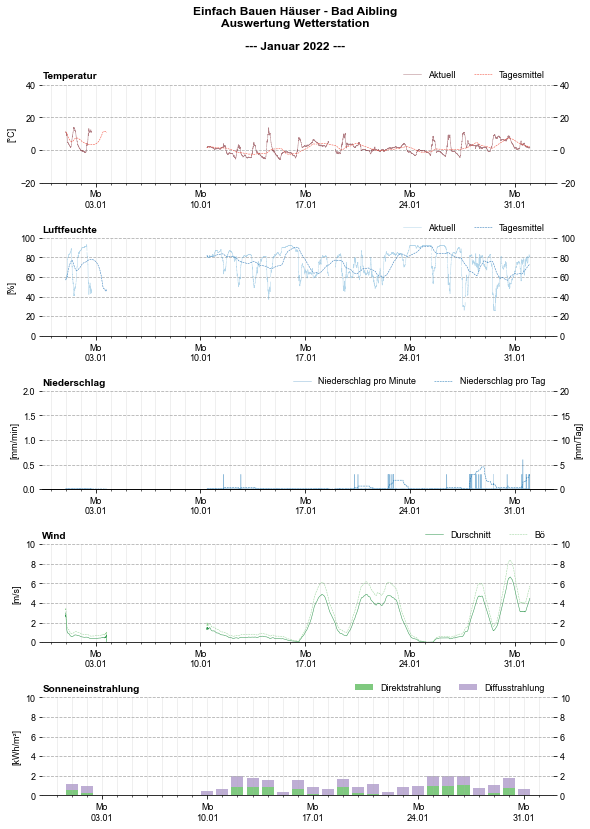

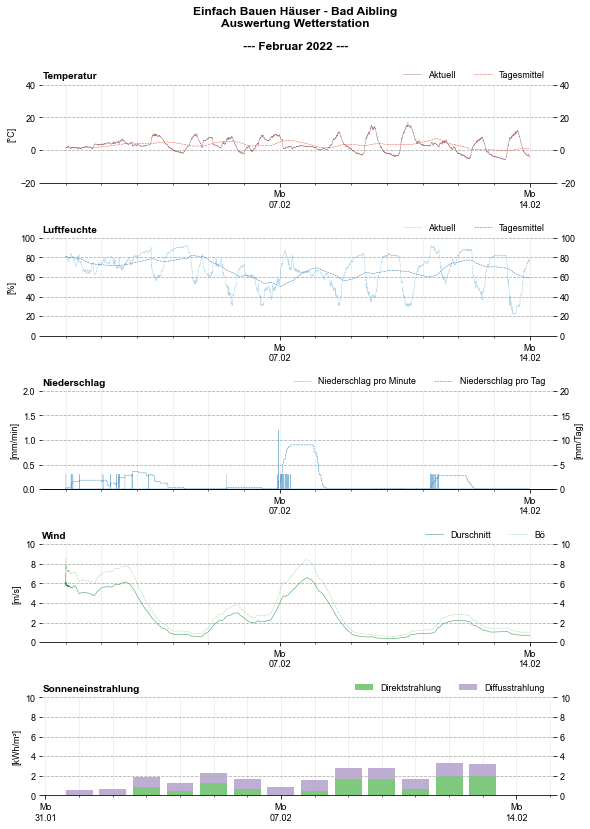

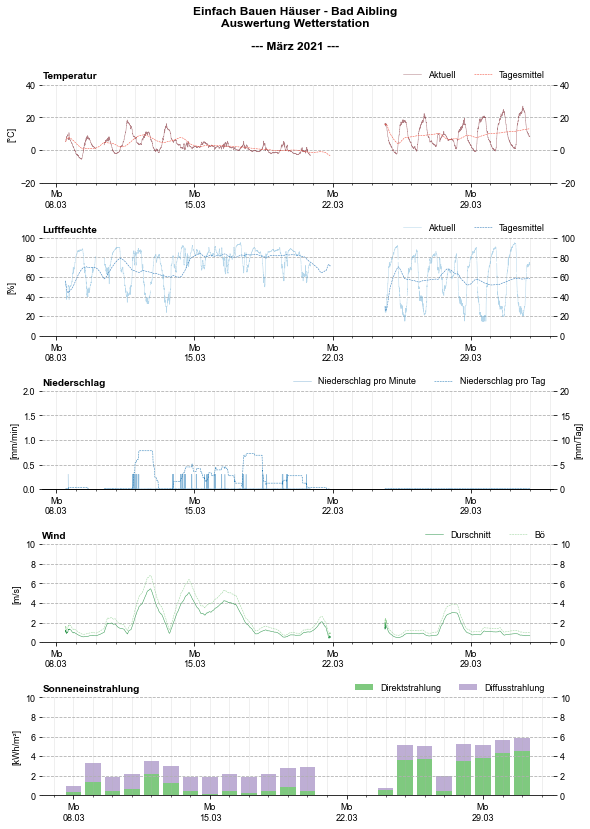

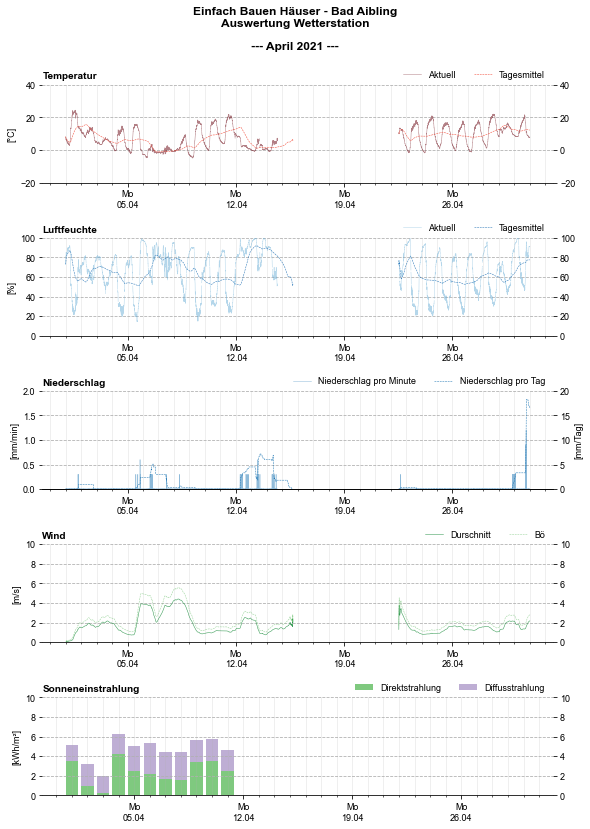

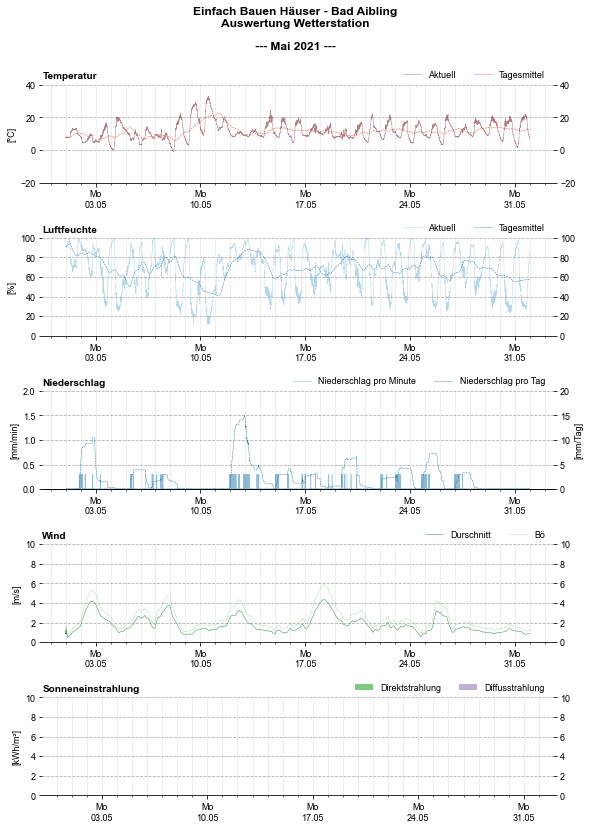

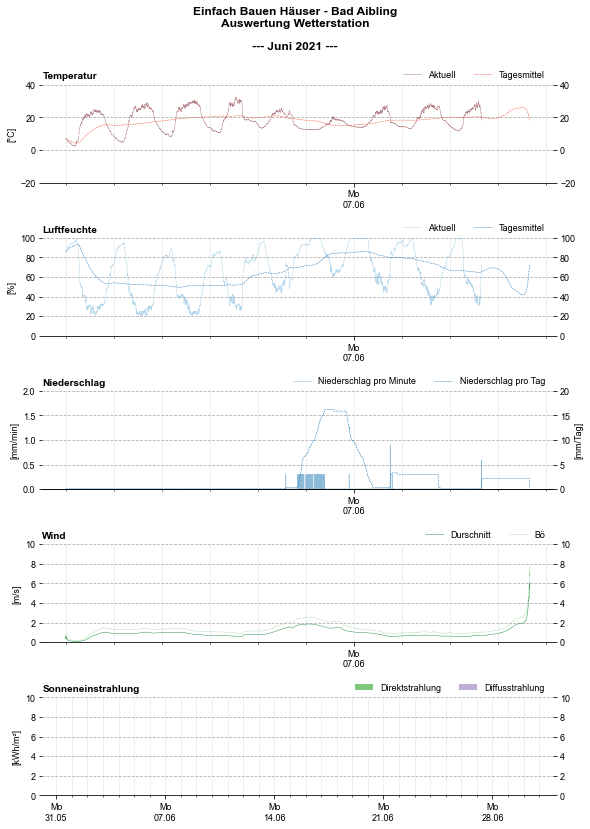

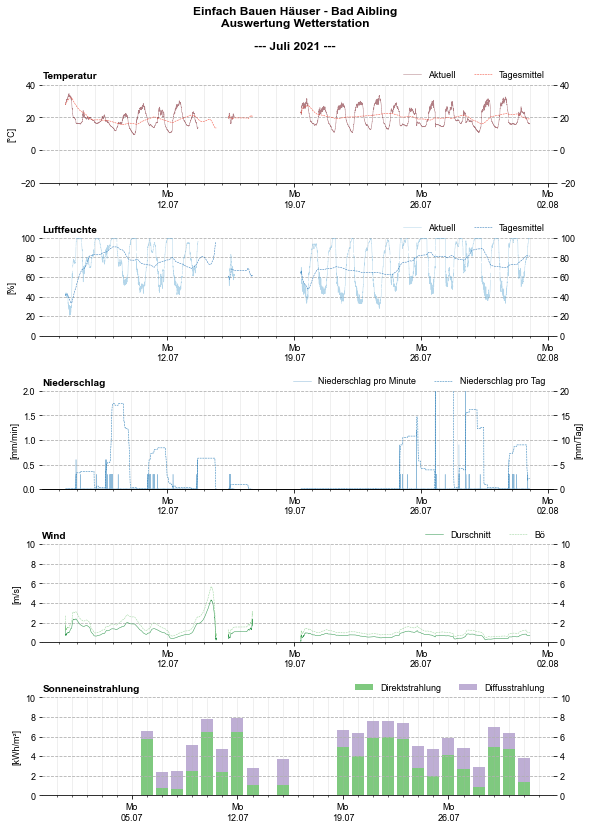

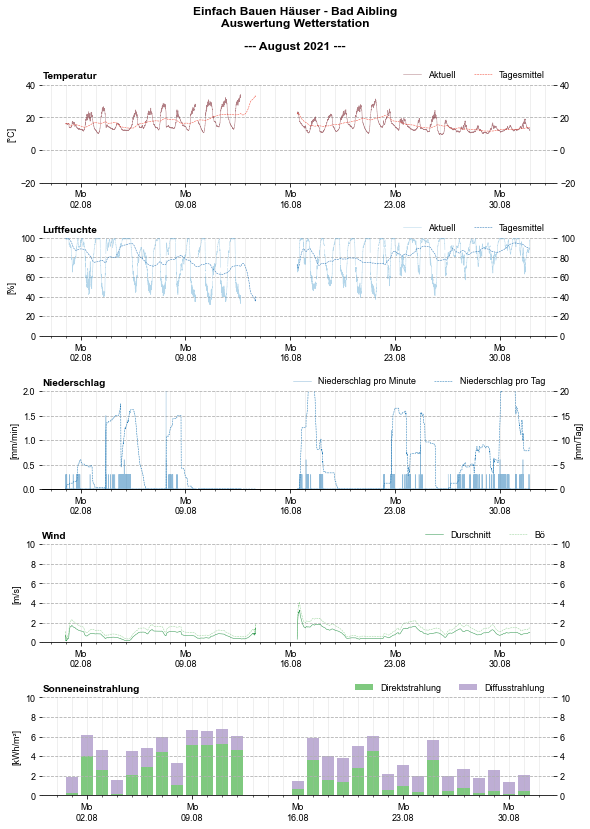

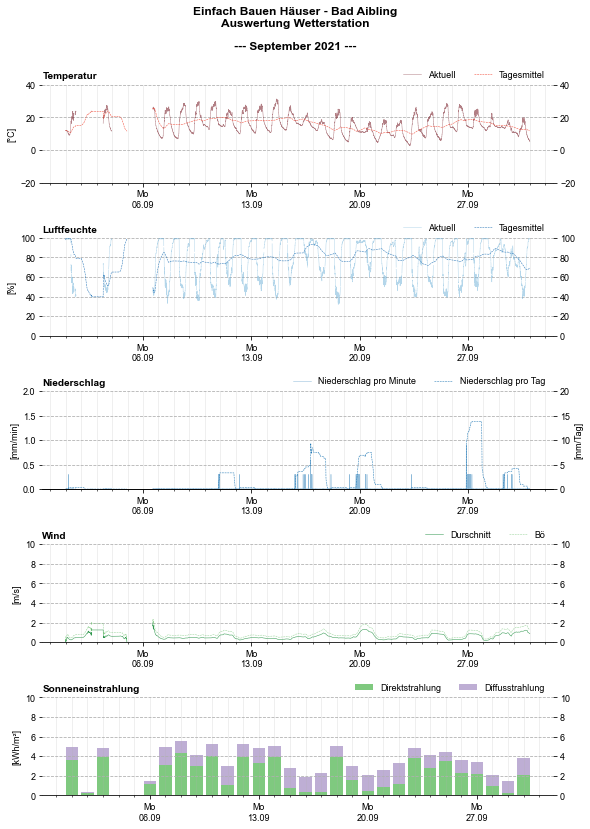

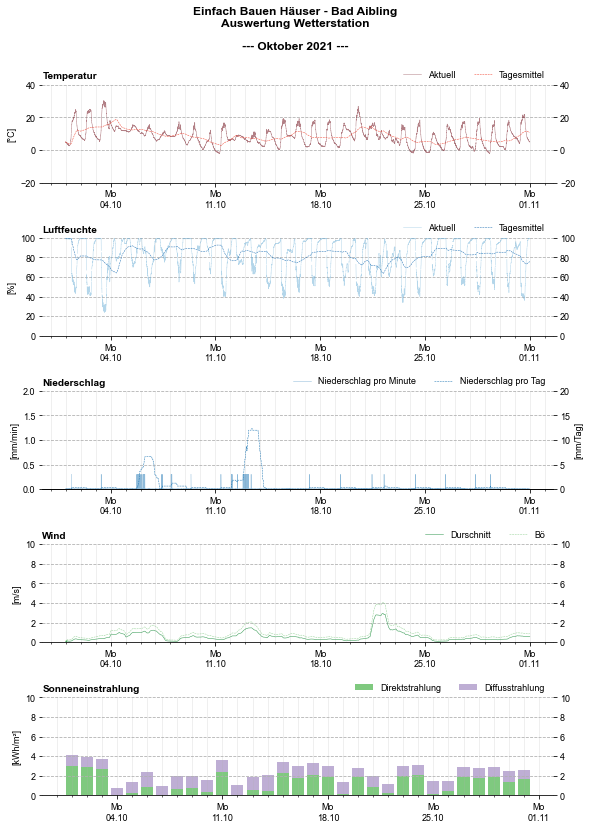

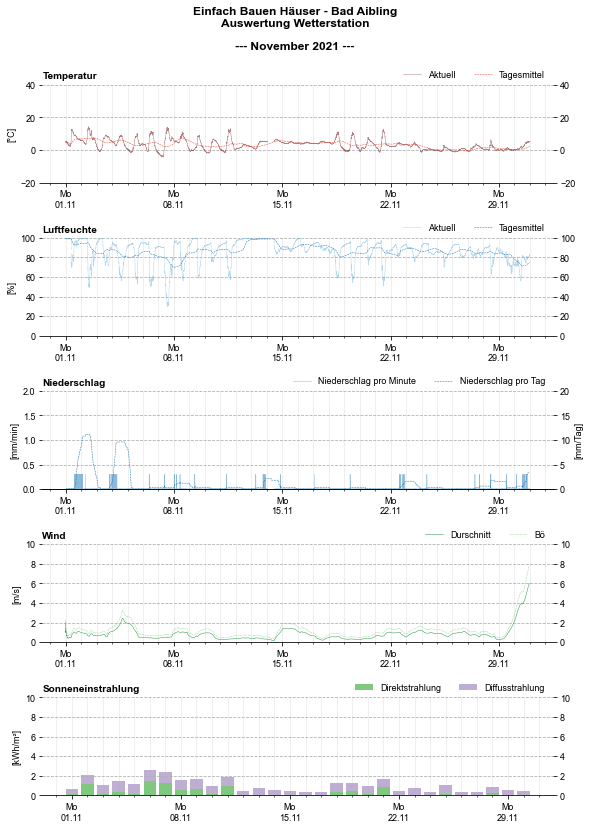

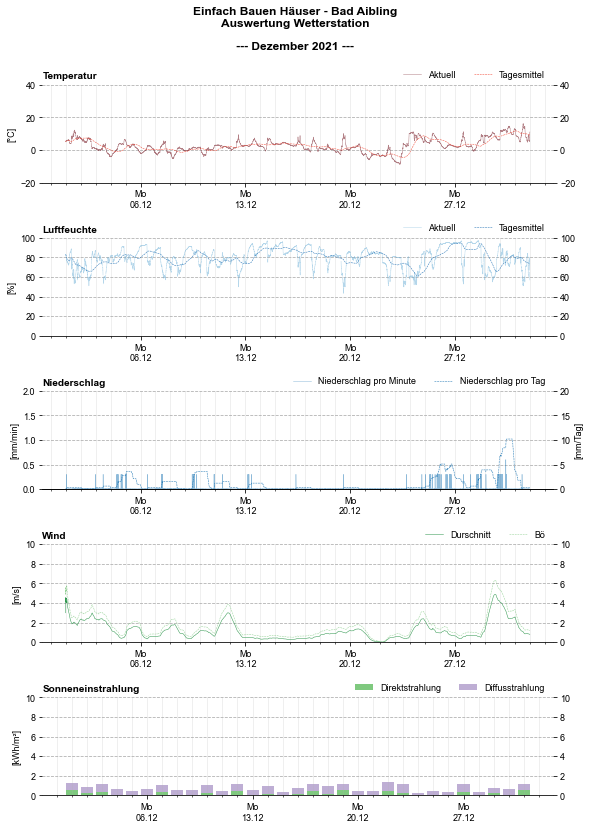

In [3]:
with PdfPages(os.path.join(eb.dir_results,'Wetterstation','Wetter_monatlich.pdf')) as pdf:
    for date, amb in AMB.groupby(by=[AMB.index.month, AMB.index.year]):
        date = dt.date(date[1], date[0], 1)
        fig, axs = plt.subplots(5,1,figsize=style.din_a4)
        fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n\n--- {date.strftime("%B %Y")} ---\n', fontweight = 'bold')
        i=0
        #----#1: Temperaturen ----
        axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[°C]')
        axs[i].set_ylim(-20,40)
        axs[i].plot(amb.T_amb,alpha=0.5,label='Aktuell')
        axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        ut.recolor_lines(axs[i], style.c_temp)
        axs[i].grid(axis='y', ls = 'dashed')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#2: Luftfeuchte ----
        axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[%]')
        axs[i].set_ylim(0,100)
        axs[i].plot(amb.Rh_amb,alpha=0.5,label='Aktuell')
        axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        ut.recolor_lines(axs[i], 'Blues', minint=0.5,maxint=1)
        axs[i].grid(axis='y', ls = 'dashed')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Niederschlag ----
        # Plot aktueller Niederschlag (pro Minute)
        axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[mm/min]')
        axs[i].set_ylim(0,2)
        axs[i].plot(amb.rain.diff(),alpha=0.5,label='Niederschlag pro Minute')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dashed')
        #axs[i].legend(loc='upper center',ncol=5,frameon=False)

        #Plot summierter Niederschlag pro Tag
        i+=1
        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
        #axs[i].grid(axis='y', ls = 'dashed')
        axs[i].set_ylim(0,20)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2

        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Wind ----

        axs[i].set_title('Wind', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[m/s]')
        axs[i].plot(amb.windspeed.rolling('D').mean(),alpha=1, label = 'Durschnitt')  
        axs[i].plot(amb.gustspeed.rolling('D').mean(),alpha=0.75,label = 'Bö',linestyle='dashed')  
        ut.recolor_lines(axs[i], 'Greens_r', minint=0.3,maxint=0.7)
        axs[i].grid(axis='y', ls = 'dashed')
        axs[i].set_ylim(0,10)
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1

        #----#4: Globalstrahlung ----
        
        axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[kWh/m²]')
        axs[i].set_ylim(0,10)
        df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

        #axs[i].bar(df_p.index, df_p['global'], label='global', color=plt.cm.Accent(0), align='edge')
        #axs[i].bar(df_p.index,df_p['direct'],bottom = df_p['global'], label='direct',color=plt.cm.Accent(0.5))

        axs[i].bar(df_p.index, df_p['direct'], bottom = 0,color=plt.cm.Accent(0), label = 'Direktstrahlung')
        axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Accent(1), label = 'Diffusstrahlung')

        axs[i].grid(axis='y', ls = 'dashed')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m'))
            #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a'))
            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
            ax.grid(axis='x',which='both',alpha=0.25)
            ax.spines['bottom'].set_visible(True)
            
        fig.tight_layout()
        pdf.savefig(fig)
        #if not ex: break

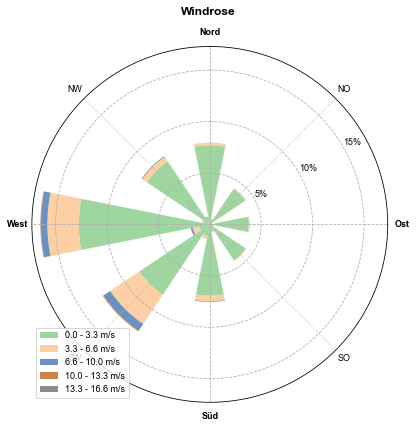

In [10]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  AMB.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

bins = np.linspace(W.windspeed.min(), W.windspeed.max(), 6)
labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

columns = ['bin{}'.format(i) for i in range(6)]
rose = pd.DataFrame(index=W.winddir.value_counts().index, columns=columns)

for i in range(1,6):
    rose[columns[i]] = W[(W.windspeed > bins[i-1]) & (W.windspeed <= bins[i])].groupby("winddir").size()/W.groupby('winddir').size().sum()
rose = rose*100

rose['theta'] = rose.index
rose.theta.replace(wind,inplace=True)
rose['deg'] =  rose.theta.apply(np.rad2deg)
rose.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize = (6,6), subplot_kw={'projection': 'polar'})

fig.suptitle('Windrose',fontweight='bold')

w = 2*np.pi/(16)

_colors = plt.cm.Accent(np.linspace(0,1,5))

ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

ax.set_theta_direction(-1)

ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
ax.set_xticklabels(['NO','SO','SW','NW'],minor=True)
ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')

ax.set_theta_zero_location('N')

ax.grid(linestyle='dashed')
ax.grid(linestyle='dotted',which='minor')

ax.set_rlabel_position(60)
ax.legend(loc=3,frameon=True)
ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

fig.tight_layout()

if ex:
    ut.export(fig,filepath=os.path.join(eb.dir_results,'Wetterstation'),filename='Windrose', extlist=['pdf','png'])

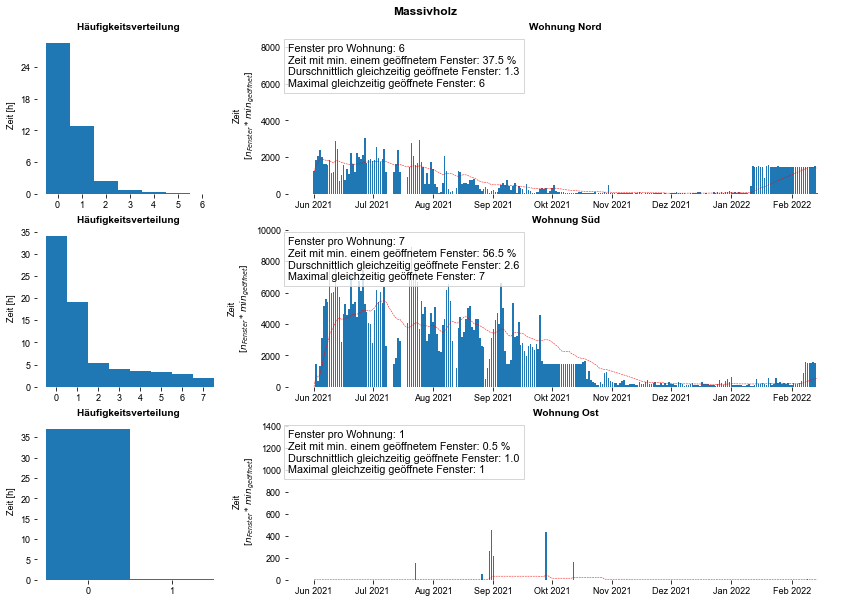

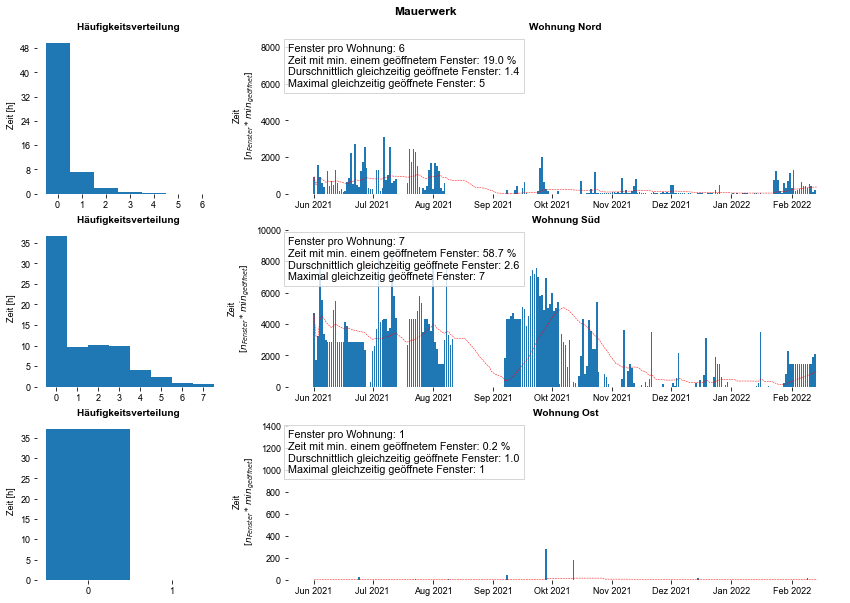

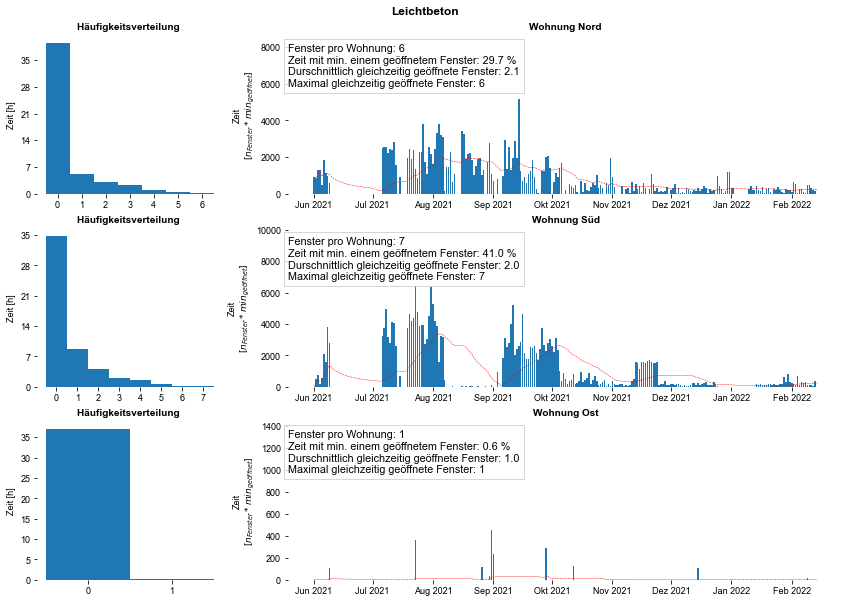

In [12]:
for bui in eb.buid:
    ind = IND[bui].loc['2021-06-01':]
    fig = plt.figure(figsize=style.din_a4_landscape,constrained_layout=True)
    gs = GridSpec(3, 4, figure=fig)
    axs=[]

    fig.suptitle('{}'.format(eb.buid[bui]),fontweight='bold')
    for i, app in enumerate(eb.wohnungen):
        axs.append([])
        dfs = []

        for room in eb.rooms:
            try:
                idx = []
                df = ind[app][room].filter(like='reed')                    
                """for window in df.columns.str.split(' ',expand=True).droplevel(level=1).unique():
                    if len(df.filter(like=window).columns) > 1:
                        df.iloc[:,1] = df.filter(like=window).iloc[:,1].fillna(df.filter(like=window).iloc[:,0])
                        df.drop(df.filter(like=window).iloc[:,0].name,axis=1,inplace=True)"""
                df.replace(['Closed','Open'],[0,1],inplace=True)
                for f,col in enumerate(df.columns):
                    t = col.split(' ')
                    ori = t[0].split('_')[0]
                    idx.append((room,'{}{}_{}'.format(ori,f, t[1])))
                df.columns = pd.MultiIndex.from_tuples(idx)
                dfs.append(df)
            except:
                continue

        df = pd.concat(dfs).resample('1min').max()

        n=len(df.columns)
        df1 = df.sum(axis=1)
        df1 = df1[df1 > 0]
        counts = df1.value_counts(normalize=True)
        gl = round(df1.dropna().mean(),1)
        ventkoeff = round(df.max(axis=1).value_counts(normalize=True)[1.0]*100,1)    #Anteil der Zeit in der Fenster geöffnet sind. Gewichtet nach Anzahl der Fenster.
        
        ### Histogramm
        j=0
        axs[i].append(fig.add_subplot(gs[i, 0]))
        df3 = df.sum(axis=1)
        df3.hist(ax = axs[i][j],bins=np.linspace(0,n+1,n+2), grid = False)
        axs[i][j].set_xticks(np.linspace(0,n,n+1)+0.5)
        axs[i][j].set_xticklabels(range(n+1))
        ut.ticks_to_hours(axs[i][j])
        axs[i][j].set_ylabel('Zeit [h]')
        axs[i][j].set_title('Häufigkeitsverteilung ')
        ###Timeline
        j+=1
        axs[i].append(fig.add_subplot(gs[i, 1:]))
        axs[i][j].set_title('Wohnung {}'.format(eb.wohnungen[app]),fontweight='bold')
        axs[i][j].text(
                0.0,
                0.95, 
                'Fenster pro Wohnung: {}\nZeit mit min. einem geöffnetem Fenster: {} %\nDurschnittlich gleichzeitig geöffnete Fenster: {}\nMaximal gleichzeitig geöffnete Fenster: {}'.format(n,ventkoeff,gl,int(df1.max())),      
                fontsize = 'large', 
                style='normal', 
                ha = 'left', 
                va = 'top',
                transform=axs[i][j].transAxes,
                bbox=style.eb_bbox, 
                )
        axs[i][j].set_ylim(0,24*60*n)
        axs[i][j].set_ylabel('Zeit\n' + r'$[n_{Fenster}*min_{geöffnet}]$')
        df2 = df.sum(axis=1).resample('D').sum()
        axs[i][j].bar(df2.index, df2)
        axs[i][j].plot(df2.rolling('30D').mean(),'r--')

    for ax in axs:
        ax[1].xaxis.set_major_locator(mdates.MonthLocator())
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if ex:
        ut.export(fig,filepath=os.path.join(eb.dir_results,'Lüftungsverhalten'),filename=f'{bui}_Übersicht', extlist=['pdf'])